In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from importlib import reload
import sys
sys.path.insert(1, './utils')

import torch
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print('CUDA Version ' + torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import wandb
%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "gnn-case118-random"

NVIDIA GeForce RTX 2080 Ti
CUDA Version 11.3


## Load data from file

In [2]:
import dataparamsgnn
reload(dataparamsgnn)

<module 'dataparamsgnn' from 'C:\\Users\\Windows\\Desktop\\Chadaga\\Failure Cascade\\gnnmodel\\./utils\\dataparamsgnn.py'>

In [3]:
dataParamsRandom = dataparamsgnn.dataParams(device, 'IEEE118', ['random'], 'Train')
nodeScale = torch.std(torch.abs(dataParamsRandom.nodeDataTrain[:,:,0] - dataParamsRandom.nodeDataTrain[:,:,1]))

Train data read from file ./data/IEEE118/loadrandomgenrandom.
Unique output labels on file = tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]).
 
Node features training dataset size = torch.Size([180000, 118, 2]).
Edge features training dataset size = torch.Size([180000, 179, 2]).
Trainable data sample indices = [     0      1      2 ... 179997 179998 179999].
Unique output labels in this dataset  = tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.]).


In [4]:
scalingList = np.arange(10,21)/10
dataParamsTest = dataparamsgnn.dataParams(device, 'IEEE118', scalingList, 'Test', dataParamsRandom.numOutputLabels)

Train data read from file ./data/IEEE118/load1.00gen1.00.
Unique output labels on file = tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]).
Train data read from file ./data/IEEE118/load1.10gen1.10.
Unique output labels on file = tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]).
Train data read from file ./data/IEEE118/load1.20gen1.20.
Unique output labels on file = tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]).
Train data read from file ./data/IEEE118/load1.30gen1.30.
Unique output labels on file = tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]).
Train data read from file ./data/IEEE118/load1.40gen1.40.
Unique output labels on file = tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]).
Train data read from file ./data/IEEE118/load1.50gen1.50.
Unique output labels on file = tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.]).
Train data read from file ./data/IEEE118/load1.60gen1.60.
Unique output labels on file = tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.]).
Train data read from file ./data

## Define the model 

In [5]:
import nnmodel
reload(nnmodel)

np.random.seed(0)
torch.manual_seed(0)

numNodeFeatures = 1
numHiddenFeatures = 150
hiddenLayerDepth = 2
numAvgLayers = 15
attentionLayerDepth = 30
attentionLayerWidth = 2048

pfModel = nnmodel.GCN(numNodeFeatures, numHiddenFeatures, numAvgLayers, \
                      attentionLayerDepth, attentionLayerWidth, hiddenLayerDepth, dataParamsRandom.numOutputLabels, \
                      dataParamsRandom.node2edgeAdjMatrix, dataParamsRandom.edge2edgeAdjMatrix, nodeScale, 0, False, device).to(device)

## Train the model

In [6]:
import nntrainer
reload(nntrainer)

learningRate = 0.0002935 # 2.953e-4
batchSize    = 128
weightDecay  = 0
gammaVal     = 0.99992037

criterion = torch.nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, pfModel.parameters()), lr=learningRate, betas=(0.9, 0.999), weight_decay = weightDecay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gammaVal)

nnTrainer = nntrainer.nnTrainer(device, criterion, scheduler)

print(criterion)
print('Learning rate =', learningRate)

CrossEntropyLoss()
Learning rate = 0.0002935


In [7]:
maxEpochs = 50000

In [8]:
wandbRun = wandb.init(
    project="gnn-power-cascade-case118",
    config={
    "learning_rate": learningRate,
    "batch_size": batchSize,
    "gamma": gammaVal,
    "epochs": maxEpochs,
    "dataset": str(dataParamsRandom.nodeDataTrain.shape[0]),
    'hidden_features': numHiddenFeatures,
    'hidden_layer_depth': hiddenLayerDepth,
    'average_layers': numAvgLayers,
    'attention_depth': attentionLayerDepth,
    'attention_width': attentionLayerWidth
    }
)

env: WANDB_SILENT=True
env: "WANDB_NOTEBOOK_NAME"="gnn-case118-random"


In [9]:
import livemetric
reload(livemetric)

liveMetricCalculator = livemetric.liveMetricCalculator(device, dataParamsRandom, dataParamsTest)

In [10]:
pfModel.train()
try:
    for epoch in trange(maxEpochs):        
        nodeFeatures, edgeFeatures, activeEdges = dataParamsRandom.getTrainBatch(batchSize)
        currLoss = nnTrainer.batchStep(nodeFeatures, edgeFeatures, activeEdges, pfModel, optimizer)
        
        liveMetricCalculator.batchRoutine(currLoss, epoch, pfModel, scalingList, 128)
        if(np.isnan(currLoss)  or currLoss > 1e4): break
            
except KeyboardInterrupt:
    print('Interrupted.') 
    
liveMetricCalculator.postRunRoutine(pfModel, 128)

  0%|          | 0/50000 [00:00<?, ?it/s]

Memory usage = 4.120032768/7.358906368. Interrupted.
Final running average accuracy is 85.1562%.


In [11]:
wandb.finish()

## Save the model

In [12]:
saveWeightsLocation_checkpoint = dataParamsRandom.dataDirectoryHome + '/weights'
saveWeightsLocation_checkpoint = saveWeightsLocation_checkpoint + '/checkpoint_hiddim' + str(numHiddenFeatures) + '_'
saveWeightsLocation_checkpoint = saveWeightsLocation_checkpoint + 'customizehere'
print(saveWeightsLocation_checkpoint)
# torch.save(pfModel.state_dict(), saveWeightsLocation_checkpoint)

./weights/checkpoint_hiddim150_customizehere


In [13]:
# pfModel.load_state_dict(torch.load(saveWeightsLocation_checkpoint))

## Evaluate the model for known uniform scaling values

In [14]:
import cascadewrapper
reload(cascadewrapper)
cascadeAnalysisTest = cascadewrapper.cascadeAnalysis(device, pfModel, dataParamsTest)
errorVectorListTest, lineFailureFrequencyListTest = cascadeAnalysisTest.collectAllProfileErrors('Test')

Tested on scaling value = 1.0, predicted edge labels size = torch.Size([1000, 179, 9]).
Tested on scaling value = 1.1, predicted edge labels size = torch.Size([1000, 179, 9]).
Tested on scaling value = 1.2, predicted edge labels size = torch.Size([1000, 179, 9]).
Tested on scaling value = 1.3, predicted edge labels size = torch.Size([1000, 179, 9]).
Tested on scaling value = 1.4, predicted edge labels size = torch.Size([1000, 179, 9]).
Tested on scaling value = 1.5, predicted edge labels size = torch.Size([1000, 179, 9]).
Tested on scaling value = 1.6, predicted edge labels size = torch.Size([1000, 179, 9]).
Tested on scaling value = 1.7, predicted edge labels size = torch.Size([1000, 179, 9]).
Tested on scaling value = 1.8, predicted edge labels size = torch.Size([1000, 179, 9]).
Tested on scaling value = 1.9, predicted edge labels size = torch.Size([1000, 179, 9]).
Tested on scaling value = 2.0, predicted edge labels size = torch.Size([1000, 179, 9]).


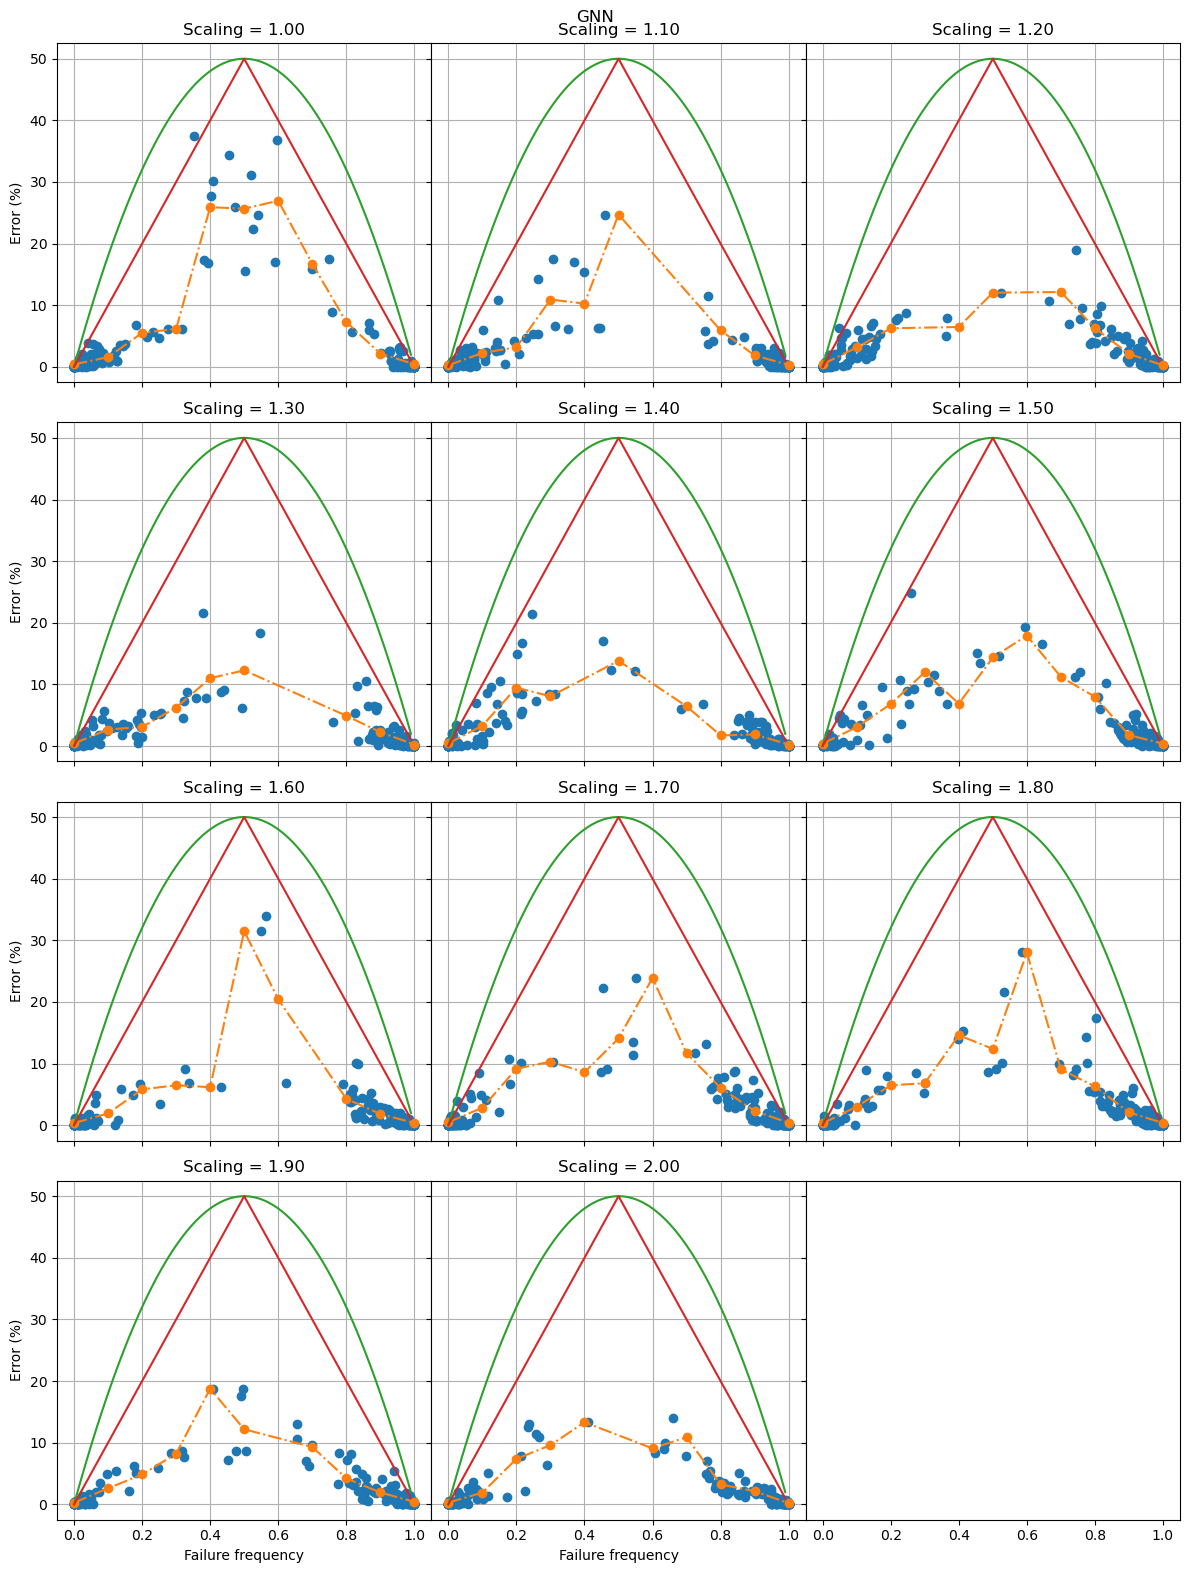

In [15]:
import plotterresults
reload(plotterresults)
resultPlotterTest = plotterresults.resultPlotter(dataParamsTest.scalingList)
resultPlotterTest.plotFinalStateError(errorVectorListTest, 4, 3, 'Status', 'GNN', lineFailureFrequencyListTest)